In [41]:
# Import Libraries
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import (LinearRegression, LogisticRegression, Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import (train_test_split, GridSearchCV)

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary
from torchvision.io import read_image
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.utilities.seed import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
ResNet50_Weights)
from torchvision.transforms import (Resize,
Normalize,
CenterCrop,
ToTensor)

c:\Users\aliso\.conda\envs\ml_upskill_env\Lib\site-packages\pytorch_lightning\utilities\seed.py:48: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 0


In [42]:
from ISLP.torch import (SimpleDataModule,
SimpleModule,
ErrorTracker,
rec_num_workers)
from ISLP.torch.imdb import (load_lookup,
load_tensor,
load_sparse,
load_sequential)
from glob import glob
import json


10.9.1 Single Layer Network on Hitters Data

In [87]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]
n

263

In [88]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [89]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()

In [90]:
X

array([[315.,  81.,   7., ...,  43.,  10.,   1.],
       [479., 130.,  18., ...,  82.,  14.,   0.],
       [496., 141.,  20., ...,  11.,   3.,   1.],
       ...,
       [475., 126.,   3., ..., 113.,   7.,   0.],
       [573., 144.,   9., ..., 131.,  12.,   0.],
       [631., 170.,   9., ...,   4.,   3.,   0.]])

In [91]:
Y

array([ 475.   ,  480.   ,  500.   ,   91.5  ,  750.   ,   70.   ,
        100.   ,   75.   , 1100.   ,  517.143,  512.5  ,  550.   ,
        700.   ,  240.   ,  775.   ,  175.   ,  135.   ,  100.   ,
        115.   ,  600.   ,  776.667,  765.   ,  708.333,  750.   ,
        625.   ,  900.   ,  110.   ,  612.5  ,  300.   ,  850.   ,
         90.   ,   67.5  ,  180.   ,  305.   ,  215.   ,  247.5  ,
        815.   ,  875.   ,   70.   , 1200.   ,  675.   ,  415.   ,
        340.   ,  416.667, 1350.   ,   90.   ,  275.   ,  230.   ,
        225.   ,  950.   ,   75.   ,  105.   ,  320.   ,  850.   ,
        535.   ,  933.333,  850.   ,  210.   ,  325.   ,  275.   ,
        450.   , 1975.   , 1900.   ,  600.   , 1041.667,  110.   ,
        260.   ,  475.   ,  431.5  , 1220.   ,   70.   ,  145.   ,
        595.   , 1861.46 ,  300.   ,  490.   , 2460.   ,  375.   ,
        750.   , 1175.   ,   70.   , 1500.   ,  385.   , 1925.571,
        215.   ,  900.   ,  155.   ,  700.   ,  535.   ,  362.

In [92]:
(X_train,
X_test,
Y_train,
Y_test) = train_test_split(X,
Y,
test_size=1/3,
random_state=1)

In [93]:
X_train

array([[491., 141.,  11., ...,   8.,   2.,   0.],
       [584., 157.,  20., ..., 421.,  11.,   0.],
       [589., 149.,  21., ...,   6.,   6.,   0.],
       ...,
       [382., 119.,  13., ..., 156.,   9.,   1.],
       [263.,  70.,   1., ..., 147.,   4.,   1.],
       [457., 101.,  14., ...,  39.,   4.,   0.]])

In [94]:
Y_train

array([ 525.   ,  420.   ,  787.5  ,   95.   ,  430.   ,  775.   ,
        670.   ,  277.5  ,  765.   ,  362.5  ,  850.   ,  105.   ,
        933.333,  530.   ,  450.   ,  215.   ,  850.   ,  875.   ,
       1310.   ,  900.   , 1260.   ,  365.   ,   75.   ,  340.   ,
        100.   ,   70.   , 1050.   ,  700.   ,  225.   ,   75.   ,
        160.   ,  260.   ,   70.   ,  940.   ,  740.   , 1237.5  ,
       1000.   ,  535.   , 1150.   ,  950.   ,  725.   ,  662.5  ,
        400.   ,  385.   ,  235.   ,  737.5  ,  740.   ,  130.   ,
       1500.   ,  657.   , 2127.333,  875.   ,  240.   ,  960.   ,
        350.   ,   90.   ,  190.   ,  175.   ,  815.   ,  140.   ,
        500.   ,  700.   ,  200.   ,  490.   ,  780.   ,   90.   ,
        200.   ,  500.   ,  500.   ,   97.5  ,  100.   ,  155.   ,
        750.   ,  375.   ,  275.   ,  110.   ,  225.   ,  575.   ,
        275.   ,  300.   ,  400.   ,  300.   ,  700.   ,  125.   ,
        750.   ,  512.5  ,   90.   ,  180.   ,   86.5  ,  650.

Linear Models

In [95]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean()

259.71528833146294

In [96]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler),
('lasso', lasso)])

In [97]:
standard_lasso

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(max_iter=30000, warm_start=True))])

In [98]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100))* lam_max}

In [117]:
param_grid

{'alpha': array([255.65755026, 244.03752004, 232.94563812, 222.35789935,
        212.25138966, 202.60423642, 193.39556119, 184.60543446,
        176.21483255, 168.20559645, 160.5603925 , 153.26267486,
        146.29664975, 139.64724123, 133.3000586 , 127.24136521,
        121.45804878, 115.93759301, 110.66805048, 105.63801679,
        100.83660589,  96.25342653,  91.87855974,  87.7025374 ,
         83.71632172,  79.9112857 ,  76.27919443,  72.81218732,
         69.50276103,  66.34375328,  63.3283273 ,  60.44995709,
         57.70241324,  55.07974951,  52.57628988,  50.18661637,
         47.9055572 ,  45.72817569,  43.64975953,  41.66581059,
         39.7720352 ,  37.96433481,  36.23879721,  34.59168794,
         33.01944234,  31.51865773,  30.08608609,  28.71862704,
         27.41332112,  26.16734337,  24.97799723,  23.8427087 ,
         22.7590208 ,  21.72458818,  20.73717211,  19.79463564,
         18.8949389 ,  18.03613476,  17.2163646 ,  16.43385426,
         15.68691022,  14.97391

In [113]:
np.linspace(0, np.log(0.01), 100)

array([ 0.        , -0.04651687, -0.09303374, -0.13955061, -0.18606748,
       -0.23258435, -0.27910122, -0.32561809, -0.37213496, -0.41865184,
       -0.46516871, -0.51168558, -0.55820245, -0.60471932, -0.65123619,
       -0.69775306, -0.74426993, -0.7907868 , -0.83730367, -0.88382054,
       -0.93033741, -0.97685428, -1.02337115, -1.06988802, -1.11640489,
       -1.16292176, -1.20943863, -1.25595551, -1.30247238, -1.34898925,
       -1.39550612, -1.44202299, -1.48853986, -1.53505673, -1.5815736 ,
       -1.62809047, -1.67460734, -1.72112421, -1.76764108, -1.81415795,
       -1.86067482, -1.90719169, -1.95370856, -2.00022543, -2.0467423 ,
       -2.09325918, -2.13977605, -2.18629292, -2.23280979, -2.27932666,
       -2.32584353, -2.3723604 , -2.41887727, -2.46539414, -2.51191101,
       -2.55842788, -2.60494475, -2.65146162, -2.69797849, -2.74449536,
       -2.79101223, -2.8375291 , -2.88404598, -2.93056285, -2.97707972,
       -3.02359659, -3.07011346, -3.11663033, -3.1631472 , -3.20

In [100]:
0.01*lam_max

2.556575502649128

In [101]:
X_s.T.shape

(19, 175)

In [104]:
len(Y_train) #.shape

175

In [109]:
X_s.T.dot(Y_train - Y_train.mean()).shape

(19,)

In [105]:
type(Y_train)

numpy.ndarray

In [107]:
(Y_train - Y_train.mean()).shape

(175,)

In [55]:
# Lambda max: the max value where if you increase, all the predictors will be 
# removed from your model

# Want to navigate through each lambda between 0.01*lam_max and lam_max to see 
# what is the optimal lambda for the function

# In our case, we initially scaled the X's because we an uniform penalty across 
# our features.

# Then, we centered our response by using its mean. Why? 
# 

# For the X's we transformed the matrix so now each row is a specific predictor
# Then we multiplied by all the centered responses to get the absolute correlation btw
#   predictor and centered response


array([ 525.   ,  420.   ,  787.5  ,   95.   ,  430.   ,  775.   ,
        670.   ,  277.5  ,  765.   ,  362.5  ,  850.   ,  105.   ,
        933.333,  530.   ,  450.   ,  215.   ,  850.   ,  875.   ,
       1310.   ,  900.   , 1260.   ,  365.   ,   75.   ,  340.   ,
        100.   ,   70.   , 1050.   ,  700.   ,  225.   ,   75.   ,
        160.   ,  260.   ,   70.   ,  940.   ,  740.   , 1237.5  ,
       1000.   ,  535.   , 1150.   ,  950.   ,  725.   ,  662.5  ,
        400.   ,  385.   ,  235.   ,  737.5  ,  740.   ,  130.   ,
       1500.   ,  657.   , 2127.333,  875.   ,  240.   ,  960.   ,
        350.   ,   90.   ,  190.   ,  175.   ,  815.   ,  140.   ,
        500.   ,  700.   ,  200.   ,  490.   ,  780.   ,   90.   ,
        200.   ,  500.   ,  500.   ,   97.5  ,  100.   ,  155.   ,
        750.   ,  375.   ,  275.   ,  110.   ,  225.   ,  575.   ,
        275.   ,  300.   ,  400.   ,  300.   ,  700.   ,  125.   ,
        750.   ,  512.5  ,   90.   ,  180.   ,   86.5  ,  650.

In [56]:
lam_max

255.65755026491283

In [118]:
cv = KFold(10,shuffle=True,random_state=1)
grid = GridSearchCV(lasso,param_grid,cv=cv,scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(max_iter=30000, warm_start=True),
             param_grid={'alpha': array([255.65755026, 244.03752004, 232.94563812, 222.35789935,
       212.25138966, 202.60423642, 193.39556119, 184.60543446,
       176.21483255, 168.20559645, 160.5603925 , 153.26267486,
       146.29664975, 139.64724123, 133.3000586 , 127.24136521,
       121.45...
        10.81237873,  10.32093943,   9.8518368 ,   9.40405561,
         8.97662677,   8.56862523,   8.17916799,   7.80741218,
         7.45255325,   7.1138232 ,   6.79048896,   6.48185076,
         6.18724064,   5.906021  ,   5.63758323,   5.38134637,
         5.13675587,   4.90328239,   4.68042064,   4.4676883 ,
         4.26462497,   4.07079118,   3.88576744,   3.70915331,
         3.54056657,   3.37964236,   3.2260324 ,   3.07940424,
         2.93944057,   2.80583846,   2.67830877,   2.5565755 ])},
             scoring='neg_mean_absolute_error')

In [121]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

257.23820107994993

In [120]:
grid.best_estimator_

Lasso(alpha=176.21483255243294, max_iter=30000, warm_start=True)

Specifying a Network: Classes and Inheritance

In [59]:
class HittersModel(nn.Module):
    def __init__(self, input_size):
        super(HittersModel , self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
        nn.Linear(input_size, 50),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(50, 1))
    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [60]:
hit_model = HittersModel(X.shape[1])

In [61]:
summary(hit_model,
input_size=X_train.shape,
col_names=['input_size',
'output_size',
'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [62]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

In [63]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

In [64]:
max_num_workers = rec_num_workers()

In [65]:
max_num_workers

8

In [66]:
hit_dm = SimpleDataModule(hit_train,
hit_test,
batch_size=32,
num_workers=min(4, max_num_workers),
validation=hit_test)

In [67]:
hit_module = SimpleModule.regression(hit_model,
metrics={'mae':MeanAbsoluteError()})

In [68]:
hit_logger = CSVLogger('logs', name='hitters')

In [69]:
hit_trainer = Trainer(deterministic=True,
max_epochs=50,
log_every_n_steps=5,
logger=hit_logger,
callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [70]:
hit_trainer.test(hit_module, datamodule=hit_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss              104098.546875
        test_mae            229.50115966796875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 104098.546875, 'test_mae': 229.50115966796875}]

In [71]:
hit_logger.experiment.metrics_file_path

'logs\\hitters\\version_2\\metrics.csv'

In [72]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [73]:
hit_results.head()

,train_mae_step,epoch,step,valid_loss,valid_mae,train_loss,train_mae_epoch,test_loss,test_mae
0,386.986084,0,4,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0,5,145063.593750,237.685242,NaN,NaN,NaN,NaN
2,NaN,0,5,NaN,NaN,715415.25,561.457336,NaN,NaN
3,273.843872,1,9,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,11,131679.765625,236.432709,NaN,NaN,NaN,NaN


In [74]:
hit_results[0:20]

,train_mae_step,epoch,step,valid_loss,valid_mae,train_loss,train_mae_epoch,test_loss,test_mae
0,386.986084,0,4,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0,5,145063.593750,237.685242,NaN,NaN,NaN,NaN
2,NaN,0,5,NaN,NaN,715415.250000,561.457336,NaN,NaN
3,273.843872,1,9,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,11,131679.765625,236.432709,NaN,NaN,NaN,NaN
5,NaN,1,11,NaN,NaN,160950.921875,255.311279,NaN,NaN
6,172.909164,2,14,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,2,17,134666.890625,236.626312,NaN,NaN,NaN,NaN
8,NaN,2,17,NaN,NaN,178127.125000,260.604553,NaN,NaN
9,275.800659,3,19,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
hit_results.tail(20)

,train_mae_step,epoch,step,valid_loss,valid_mae,train_loss,train_mae_epoch,test_loss,test_mae
141,191.998856,44,269,NaN,NaN,NaN,NaN,NaN,NaN
142,NaN,44,269,94222.140625,211.948547,NaN,NaN,NaN,NaN
143,NaN,44,269,NaN,NaN,112292.171875,226.011826,NaN,NaN
144,219.920090,45,274,NaN,NaN,NaN,NaN,NaN,NaN
145,NaN,45,275,104263.078125,215.213608,NaN,NaN,NaN,NaN
146,NaN,45,275,NaN,NaN,97885.585938,213.715378,NaN,NaN
147,176.693680,46,279,NaN,NaN,NaN,NaN,NaN,NaN
148,NaN,46,281,132240.921875,276.999481,NaN,NaN,NaN,NaN
149,NaN,46,281,NaN,NaN,131006.375000,230.000671,NaN,NaN
150,193.140076,47,284,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
def summary_plot(results,
ax,
col='loss',
valid_legend='Validation',
training_legend='Training',
ylabel='Loss',
fontsize=20):
    for (column,
    color,
    label) in zip([f'train_{col}_epoch',
    f'valid_{col}'],
    ['black',
    'red'],
    [training_legend,
    valid_legend]):
        results.plot(x='epoch',
        y=column,
        label=label,
        marker='o',
        color=color,
        ax=ax)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
    return ax

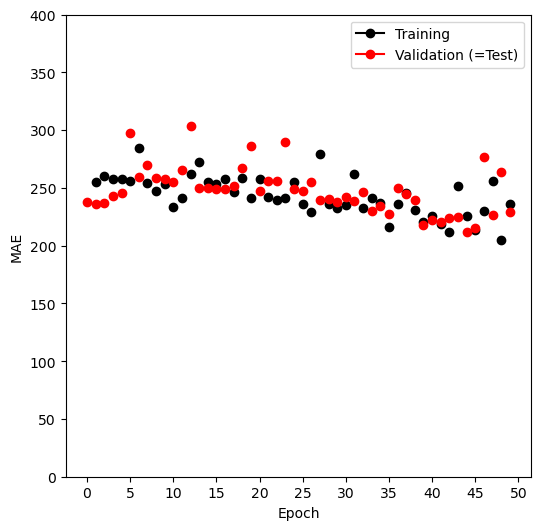

In [77]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results,
ax,
col='mae',
ylabel='MAE',
valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

In [78]:
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(229.5012, grad_fn=<MeanBackward0>)

In [79]:
del(Hitters,
hit_model, hit_dm,
hit_logger,
hit_test, hit_train,
X, Y,
X_test, X_train,
Y_test, Y_train,
X_test_t, Y_test_t,
hit_trainer, hit_module)